In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as data
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import random
from torch import optim
import math
import pypianoroll
import Functions as F

# Customized Dataset

In [2]:

class customDataset2(data.Dataset):
    def __init__(self,folder,subfolders,trainingtype):
        self.folder = folder # this contains subfolders such as mozart
        self.subfolders = subfolders
        self.trainingtype = trainingtype # this is either Train, Val, or Test
        
        subfoldername = self.subfolders # get all the subfoler names such as chopin
        
        # extract desired datasets from each of the subfolders
        all_songs = []
        for foldername in  subfoldername:
            # this gives the path of desired folder: e.g..../Chopin/Train
            dataset_path_in_subfolder = os.path.join(folder,foldername,trainingtype)
            #print("desired folder ",dataset_path_in_subfolder)
            
            # this gives the song names in the desired folder: e.g. k21_op3.mid
            songs_in_dataset = os.listdir(dataset_path_in_subfolder)
            #print("songs: ", songs_in_dataset[:3])
            
            # combine the desired path with the song names: e.g. .../Chopin/Train/k21_op3.mid
            songs = map(lambda fname: os.path.join(dataset_path_in_subfolder,fname),
                                                    songs_in_dataset)
            songs = list(songs)
            #print("songs full: ",songs[:3])
            
            # append the songs to all_songs
            all_songs.extend(songs)
            #print("all songs: ", all_songs[:3])
        
        # hold a list of full file paths
        self.fnames_ful = all_songs
        print("Total samples: ",len(all_songs))
        #print(all_songs[:10])
    
    def __len__(self):
        return len(self.fnames_ful)
    
    def __getitem__(self, index):
        fnames_ful = self.fnames_ful[index]
        roll = pd.read_csv(fnames_ful,header=None)
        roll = np.array(roll)
        # input sequence is from first element til the second last so that
        #  the model could predict from the second element til the last one
        ##input_seq = roll[:-1,:]
        input_seq = roll[:500,:] # length 500
        # we expect the model to predict the all elements
        ##output_seq = roll[-500:,:]
        ##output_seq = roll[-1000:,:]
        output_seq = roll[1:501,:] # length 500
        return (input_seq,output_seq)

# Dataloaders

In [3]:
folder = "Handcrafted Dataset - One Hot"
subfolders = os.listdir(folder)
subfolders[:10]

['Bach',
 'Beethoven',
 'Chopin',
 'Clementi',
 'Czerny',
 'Debussy',
 'Handel_Harpsichord',
 'Haydn',
 'Liszt',
 'Mendelssohn']

In [4]:
trainingtype = "Train"

train_dataset = customDataset2(folder,subfolders,trainingtype)
train_dataloader = data.DataLoader(train_dataset,batch_size=128,shuffle=True)

Total samples:  29431


In [5]:
# check
X_train=next(iter(train_dataloader))
print(X_train[0].shape) # input seq
print(X_train[1].shape) # output seq

torch.Size([128, 500, 88])
torch.Size([128, 500, 88])


In [6]:
# validation set

trainingtype="Val"
#val_dataset = customDataset(path)
val_dataset = customDataset2(folder,subfolders,trainingtype)
# seperate val set into 5 sets because validate 40,000 every time is too much
#  now it would only validate on 8,000
set1 = list(range(0,len(val_dataset),3))
set2 = list(range(1,len(val_dataset),3))
set3 = list(range(2,len(val_dataset),3))
#set4 = list(range(3,len(val_dataset),5))
#set5 = list(range(4,len(val_dataset),5))

val1 = data.Subset(val_dataset,set1)
val2 = data.Subset(val_dataset,set2)
val3 = data.Subset(val_dataset,set3)
#val4 = data.Subset(val_dataset,set4)
#val5 = data.Subset(val_dataset,set5)""

size = 128
val_dataloader1 = data.DataLoader(val1,batch_size=size,shuffle=True)
val_dataloader2 = data.DataLoader(val2,batch_size=size,shuffle=True)
val_dataloader3 = data.DataLoader(val3,batch_size=size,shuffle=True)
#val_dataloader4 = data.DataLoader(val4,batch_size=size,shuffle=True)
#val_dataloader5 = data.DataLoader(val5,batch_size=size,shuffle=True)

val_dataloaders = [val_dataloader1,
               val_dataloader2,
                val_dataloader3]

Total samples:  5211


In [7]:
# check
X_val = next(iter(val_dataloader1))
print(X_val[0].shape) # input seq
print(X_val[1].shape) # output seq

torch.Size([128, 500, 88])
torch.Size([128, 500, 88])


In [8]:
# test set
trainingtype="Test"
test_dataset = customDataset2(folder,subfolders,trainingtype)
test_dataloader = data.DataLoader(test_dataset,batch_size=128,shuffle=False)

Total samples:  3367


## visualization

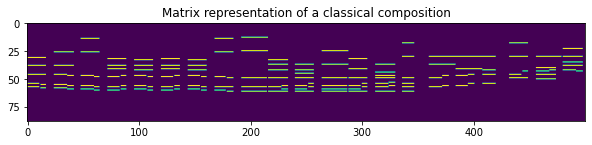

In [9]:
plt.figure(figsize=(10,7))
plt.title("Matrix representation of a classical composition")
plt.imshow(X_train[0][4][:500].T)

# Training and validation Routine

In [10]:
def evaluate(model,val_loader,device,loss_fn):
    model.eval()
    val_loss = 0.0
    steps = 0
    
    for batch in val_loader:
        steps += 1
        input_seq, output_seq = batch
        input_seq, output_seq = input_seq.to(device), output_seq.to(device)
        # try to fix error :"addmm_cuda" not implemented for 'Long'
        input_seq = input_seq.float()
        
        output_seq = output_seq.transpose(0,1).contiguous()
        output_seq = output_seq.contiguous().view(-1)
        
        final,_ = model(input_seq)
        # try to fix:"nll_loss_forward_reduce_cuda_kernel_2d_index" not implemented for 'Float'
        #final, output_seq = final.double(),output_seq.double()
        loss = loss_fn(final,output_seq)
        val_loss += loss.item()
    
    print("The mean validation loss is %.4f" % (val_loss/steps))
    print()
    return val_loss/steps

In [11]:
def train(model,trainloader,valloaders,ep,print_freq,loss_fun,
          optimizer,device,run,grad_clip=1.0,mname="LSTM"):
    val_loss_best = float("inf")
    
    # total number of training steps
    num_steps = ep * (len(trainloader))
    progress_bar = tqdm(range(num_steps))
    
    # calculate how often print the result
    #  if num_step = 12, and print_freq = 3, then print every 4 steps
    print_every = math.floor(num_steps/print_freq)
    
    # initialize
    steps = 0
    #model.to(device) ## error when run this twice
    model.train()
    train_losses = []
    val_losses = []
    which_val = 0
    
    for e in range(ep):
        current_loss = 0
        for batch in trainloader:
            input_s, output_s = batch
            steps += 1
            input_seq, output_seq = input_s.to(device), output_s.to(device)
            # try to fix error :"addmm_cuda" not implemented for 'Long'
            #  note: output_seq should stay long (int)
            input_seq = input_seq.float()
            #print("input shape: ",input_seq.shape)
            
            output_seq = output_seq.transpose(0,1).contiguous()
            #print("original output shape: ", output_seq.shape)
            output_seq = output_seq.contiguous().view(-1)
            
            #print("output shape: ", output_seq.shape)
            #print("largest output: ", torch.max(output_seq))
            
            # calculate grad and update
            optimizer.zero_grad()
            final,_ = model(input_seq)
            #print("prediction shape: ", final.shape)
            #print("largest prediction: ", torch.max(final.permute(1,0)[0]))
            # calculate loss and record loss
            # try to fix:"nll_loss_forward_reduce_cuda_kernel_2d_index" not implemented for 'Float'
            #final, output_seq = final.double(),output_seq.double()
            #print("final shape: ", final.shape) # (,2)
            #print("output shape: ", output_seq.shape)
            #print("final: ",final[:2,:])
            #print("output_seq:",output_seq[:2])
            loss = loss_fun(final, output_seq)
            #print("loss: ", loss)
            train_losses.append(loss.item())
            current_loss += loss.item()
            #print(current_loss)
            # update parameter
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(),grad_clip)
            optimizer.step()
            
            # update progress bar
            progress_bar.update(1)
            
            # print if reach the threshold we want
            if steps % print_every == 0:
                # training loss: divided by the number of steps taken during training
                #  from last print to current print
                print('EPOCHS : {}/{}'.format(e+1,ep),
                          'Loss : {:.6f}'.format(current_loss/print_every))

                current_loss = 0
                #which_val = random.randint(0,4)
                which_val = random.randint(0,2) # now I only have 2 val sets
                # val loss: divided by the number of steps taken when validate
                val_loss = evaluate(model,valloaders[which_val],device,loss_fun)
                val_losses.append(val_loss)
                
                # add call back
                if val_loss < val_loss_best:
                    val_loss_best = val_loss
                    torch.save(model.state_dict(),
                     "Handcrafted Dataset - One Hot Weights/"+mname+"-run-{}-val_loss-BEST.pth".format(run))
            model.train()
    torch.save(model.state_dict(),
         "Handcrafted Dataset - One Hot Weights/"+mname+"-run-{}-val_loss-LAST.pth".format(run))
    return train_losses, val_losses

# Model

# Length 3000

In [12]:
class BaseLSTM(nn.Module):
    def __init__(self, input_size = 88, embed_size = 512, hidden_size = 1024, 
                  num_class = 88, layers = 2):
        super(BaseLSTM, self).__init__()
        self.input_size = input_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_class = num_class
        self.layers = layers
        self.notes_encoder = nn.Linear(in_features=input_size, out_features=embed_size)
        self.layernorm_encoder = nn.LayerNorm(embed_size)
        self.layernorm_lstm = nn.LayerNorm(hidden_size)
        self.lstm = nn.LSTM(embed_size,hidden_size,layers)
        self.final = nn.Linear(hidden_size,num_class)
        ###
        #self.final = nn.Linear(hidden_size,128)
        #self.final2 = nn.Linear(128,num_class)
        #self.relu = nn.ReLU()
        ###
        
    def forward(self,sequences,hidden=None):
        # seq shape (batch,seq_len,88)
        notes_encoded = self.notes_encoder(sequences) # shape (batch,seq_len,embed_size)
        #notes_rolled = notes_encoded.permute(1,2,0).contiguous()
                                                      # shape (seq_len,embed_size,batch)
        notes_rolled = notes_encoded
        notes_lnormed = self.layernorm_encoder(notes_rolled)
        notes_lnormed = nn.Dropout(0.1)(notes_lnormed)
        #notes = notes_lnormed.permute(2,0,1)          # shape (batch,seq_len,embed_size)
        notes = notes_lnormed
        
        # output shape (batch,seq_len,hidden_size)
        output, hidden = self.lstm(notes,hidden)
        
        #output_lnormed = self.layernorm_lstm(output.permute(1,2,0).contiguous())
        output_lnormed = self.layernorm_lstm(output)
        output_lnormed = nn.Dropout(0.1)(output_lnormed)
        

        
        # only take the final 1000
        #output_lnormed = output_lnormed[:,-1000:,:] 
        
        # final shape (batch,200,num_class)
        #final = self.final(output_lnormed.permute(2,0,1))
        final = self.final(output_lnormed) # final (batch,200,hidden_size) --> 
                                            #                 (batch,200,88)
        
        ###
        #final = self.relu(final)
        #final = nn.Dropout(0.5)(final)
        #final = self.final2(final)
        
        
        ###
        
        # final shape (200,batch,88)
        final = final.transpose(0,1).contiguous()
        #print("original final shape: ", final.shape)
        
        # create a second measure for prediction per class, shape(seq_len,batch,num_class)
        neg_final = 1 - final
        
        # two "predictions" for each node
        zero_one_final = torch.stack((final,neg_final),dim=3).contiguous()
        
        # flatten everything except for the two predictions dimension
        flatten_final = zero_one_final.view(-1,2)
        
        return flatten_final, hidden

In [41]:
# experiment
a = torch.tensor([1,2,3])
b = torch.tensor([4,5,6])
c = torch.stack((a,b),dim=1)
c

tensor([[1, 4],
        [2, 5],
        [3, 6]])

In [13]:
baseModel = BaseLSTM(input_size = 88, embed_size = 512, hidden_size = 512, 
                  num_class = 88, layers = 2).cuda()

weights = torch.cuda.FloatTensor([1.0,2.0])
loss_fun = nn.CrossEntropyLoss(weights)
optimizer = optim.AdamW(baseModel.parameters(),lr=1e-4)

Batchsize = 16

In [14]:
train_loss, val_loss = train(baseModel,train_dataloader,val_dataloaders,1,40,
      loss_fun,optimizer,'cuda',1,grad_clip=1.0,mname="BaseLSTM")

  0%|          | 0/1840 [00:00<?, ?it/s]

EPOCHS : 1/1 Loss : 0.287788
The mean validation loss is 0.1656

EPOCHS : 1/1 Loss : 0.127989
The mean validation loss is 0.0917

EPOCHS : 1/1 Loss : 0.070552
The mean validation loss is 0.0550

EPOCHS : 1/1 Loss : 0.049597
The mean validation loss is 0.0454

EPOCHS : 1/1 Loss : 0.042761
The mean validation loss is 0.0413

EPOCHS : 1/1 Loss : 0.041020
The mean validation loss is 0.0391

EPOCHS : 1/1 Loss : 0.039075
The mean validation loss is 0.0377

EPOCHS : 1/1 Loss : 0.036907
The mean validation loss is 0.0368

EPOCHS : 1/1 Loss : 0.036365
The mean validation loss is 0.0361

EPOCHS : 1/1 Loss : 0.035822
The mean validation loss is 0.0356

EPOCHS : 1/1 Loss : 0.034977
The mean validation loss is 0.0351

EPOCHS : 1/1 Loss : 0.034478
The mean validation loss is 0.0347

EPOCHS : 1/1 Loss : 0.034747
The mean validation loss is 0.0343

EPOCHS : 1/1 Loss : 0.033055
The mean validation loss is 0.0340

EPOCHS : 1/1 Loss : 0.034993
The mean validation loss is 0.0343

EPOCHS : 1/1 Loss : 0.034

In [15]:
optimizer = optim.AdamW(baseModel.parameters(),lr=1e-5)
train_loss, val_loss = train(baseModel,train_dataloader,val_dataloaders,1,40,
      loss_fun,optimizer,'cuda',2,grad_clip=1.0,mname="BaseLSTM")

  0%|          | 0/1840 [00:00<?, ?it/s]

EPOCHS : 1/1 Loss : 0.032765
The mean validation loss is 0.0316

EPOCHS : 1/1 Loss : 0.031376
The mean validation loss is 0.0315

EPOCHS : 1/1 Loss : 0.032659
The mean validation loss is 0.0317

EPOCHS : 1/1 Loss : 0.031982
The mean validation loss is 0.0316

EPOCHS : 1/1 Loss : 0.031212
The mean validation loss is 0.0316

EPOCHS : 1/1 Loss : 0.032325
The mean validation loss is 0.0317

EPOCHS : 1/1 Loss : 0.032859
The mean validation loss is 0.0316

EPOCHS : 1/1 Loss : 0.032216
The mean validation loss is 0.0317

EPOCHS : 1/1 Loss : 0.032531
The mean validation loss is 0.0317

EPOCHS : 1/1 Loss : 0.031385
The mean validation loss is 0.0315

EPOCHS : 1/1 Loss : 0.032410
The mean validation loss is 0.0316

EPOCHS : 1/1 Loss : 0.031887
The mean validation loss is 0.0317

EPOCHS : 1/1 Loss : 0.032050
The mean validation loss is 0.0316

EPOCHS : 1/1 Loss : 0.031609
The mean validation loss is 0.0315

EPOCHS : 1/1 Loss : 0.031862
The mean validation loss is 0.0316

EPOCHS : 1/1 Loss : 0.032

In [52]:
# experiment
train_loss, val_loss = train(baseModel,train_dataloader,val_dataloaders,1,40,
      loss_fun,optimizer,'cuda',2,grad_clip=1.0,mname="BaseLSTM")

  0%|          | 0/1840 [00:00<?, ?it/s]

final shape:  torch.Size([4222592, 2])
output shape:  torch.Size([4222592])
final:  tensor([[ 6.2297, -5.2297],
        [ 6.0876, -5.0876]], device='cuda:0', grad_fn=<SliceBackward0>)
output_seq: tensor([0, 0], device='cuda:0')
loss:  tensor(0.0260, device='cuda:0', grad_fn=<NllLossBackward0>)
final shape:  torch.Size([4222592, 2])
output shape:  torch.Size([4222592])
final:  tensor([[ 6.0642, -5.0642],
        [ 5.5984, -4.5984]], device='cuda:0', grad_fn=<SliceBackward0>)
output_seq: tensor([0, 0], device='cuda:0')
loss:  tensor(0.0325, device='cuda:0', grad_fn=<NllLossBackward0>)
final shape:  torch.Size([4222592, 2])
output shape:  torch.Size([4222592])
final:  tensor([[ 4.6328, -3.6328],
        [ 4.6878, -3.6878]], device='cuda:0', grad_fn=<SliceBackward0>)
output_seq: tensor([0, 0], device='cuda:0')
loss:  tensor(0.0316, device='cuda:0', grad_fn=<NllLossBackward0>)
final shape:  torch.Size([4222592, 2])
output shape:  torch.Size([4222592])
final:  tensor([[ 5.6609, -4.6609],
   

KeyboardInterrupt: 

# try without weighted loss - baseModel2
batch_size = 16

In [13]:
baseModel2 = BaseLSTM(input_size = 88, embed_size = 512, hidden_size = 512, 
                  num_class = 88, layers = 2).cuda()

#weights = torch.cuda.FloatTensor([1.0,2.0])
loss_fun = nn.CrossEntropyLoss()
optimizer = optim.AdamW(baseModel2.parameters(),lr=1e-4)

In [14]:
train_loss, val_loss = train(baseModel2,train_dataloader,val_dataloaders,1,40,
      loss_fun,optimizer,'cuda',1,grad_clip=1.0,mname="BaseLSTM2")

  0%|          | 0/1840 [00:00<?, ?it/s]

EPOCHS : 1/1 Loss : 0.260530
The mean validation loss is 0.1132

EPOCHS : 1/1 Loss : 0.101901
The mean validation loss is 0.0895

EPOCHS : 1/1 Loss : 0.067828
The mean validation loss is 0.0515

EPOCHS : 1/1 Loss : 0.042426
The mean validation loss is 0.0357

EPOCHS : 1/1 Loss : 0.033910
The mean validation loss is 0.0302

EPOCHS : 1/1 Loss : 0.028896
The mean validation loss is 0.0278

EPOCHS : 1/1 Loss : 0.027414
The mean validation loss is 0.0262

EPOCHS : 1/1 Loss : 0.026193
The mean validation loss is 0.0254

EPOCHS : 1/1 Loss : 0.025131
The mean validation loss is 0.0246

EPOCHS : 1/1 Loss : 0.024479
The mean validation loss is 0.0242

EPOCHS : 1/1 Loss : 0.023573
The mean validation loss is 0.0238

EPOCHS : 1/1 Loss : 0.023805
The mean validation loss is 0.0236

EPOCHS : 1/1 Loss : 0.023733
The mean validation loss is 0.0233

EPOCHS : 1/1 Loss : 0.022963
The mean validation loss is 0.0229

EPOCHS : 1/1 Loss : 0.023165
The mean validation loss is 0.0229

EPOCHS : 1/1 Loss : 0.023

In [15]:
optimizer = optim.AdamW(baseModel2.parameters(),lr=1e-6)
train_loss, val_loss = train(baseModel2,train_dataloader,val_dataloaders,1,40,
      loss_fun,optimizer,'cuda',2,grad_clip=1.0,mname="BaseLSTM2")

  0%|          | 0/1840 [00:00<?, ?it/s]

EPOCHS : 1/1 Loss : 0.020578
The mean validation loss is 0.0213

EPOCHS : 1/1 Loss : 0.021792
The mean validation loss is 0.0212

EPOCHS : 1/1 Loss : 0.021543
The mean validation loss is 0.0211

EPOCHS : 1/1 Loss : 0.021385
The mean validation loss is 0.0213

EPOCHS : 1/1 Loss : 0.021034
The mean validation loss is 0.0212

EPOCHS : 1/1 Loss : 0.021757
The mean validation loss is 0.0210

EPOCHS : 1/1 Loss : 0.021155
The mean validation loss is 0.0211

EPOCHS : 1/1 Loss : 0.021290
The mean validation loss is 0.0212

EPOCHS : 1/1 Loss : 0.021310
The mean validation loss is 0.0211

EPOCHS : 1/1 Loss : 0.021367
The mean validation loss is 0.0212

EPOCHS : 1/1 Loss : 0.021680
The mean validation loss is 0.0213

EPOCHS : 1/1 Loss : 0.021300
The mean validation loss is 0.0211

EPOCHS : 1/1 Loss : 0.021401
The mean validation loss is 0.0210

EPOCHS : 1/1 Loss : 0.021553
The mean validation loss is 0.0212

EPOCHS : 1/1 Loss : 0.021853
The mean validation loss is 0.0211

EPOCHS : 1/1 Loss : 0.021

In [16]:
optimizer = optim.AdamW(baseModel2.parameters(),lr=1e-7)
train_loss, val_loss = train(baseModel2,train_dataloader,val_dataloaders,1,10,
      loss_fun,optimizer,'cuda',3,grad_clip=1.0,mname="BaseLSTM2")

  0%|          | 0/1840 [00:00<?, ?it/s]

EPOCHS : 1/1 Loss : 0.021402
The mean validation loss is 0.0210

EPOCHS : 1/1 Loss : 0.021311
The mean validation loss is 0.0210

EPOCHS : 1/1 Loss : 0.021257
The mean validation loss is 0.0211

EPOCHS : 1/1 Loss : 0.021039
The mean validation loss is 0.0210

EPOCHS : 1/1 Loss : 0.021405
The mean validation loss is 0.0212

EPOCHS : 1/1 Loss : 0.021243
The mean validation loss is 0.0210

EPOCHS : 1/1 Loss : 0.021566
The mean validation loss is 0.0211

EPOCHS : 1/1 Loss : 0.021170
The mean validation loss is 0.0210

EPOCHS : 1/1 Loss : 0.021452
The mean validation loss is 0.0212

EPOCHS : 1/1 Loss : 0.021468
The mean validation loss is 0.0211



In [17]:
train_loss, val_loss = train(baseModel2,train_dataloader,val_dataloaders,1,10,
      loss_fun,optimizer,'cuda',4,grad_clip=1.0,mname="BaseLSTM2")

  0%|          | 0/1840 [00:00<?, ?it/s]

EPOCHS : 1/1 Loss : 0.021479
The mean validation loss is 0.0212

EPOCHS : 1/1 Loss : 0.021402
The mean validation loss is 0.0211

EPOCHS : 1/1 Loss : 0.021408
The mean validation loss is 0.0211

EPOCHS : 1/1 Loss : 0.021388
The mean validation loss is 0.0212

EPOCHS : 1/1 Loss : 0.021044
The mean validation loss is 0.0211

EPOCHS : 1/1 Loss : 0.021329
The mean validation loss is 0.0211

EPOCHS : 1/1 Loss : 0.021324
The mean validation loss is 0.0211

EPOCHS : 1/1 Loss : 0.021307
The mean validation loss is 0.0211

EPOCHS : 1/1 Loss : 0.021337
The mean validation loss is 0.0212

EPOCHS : 1/1 Loss : 0.021343
The mean validation loss is 0.0211



In [18]:
train_loss, val_loss = train(baseModel2,train_dataloader,val_dataloaders,1,10,
      loss_fun,optimizer,'cuda',5,grad_clip=1.0,mname="BaseLSTM2")

  0%|          | 0/1840 [00:00<?, ?it/s]

EPOCHS : 1/1 Loss : 0.021228
The mean validation loss is 0.0210

EPOCHS : 1/1 Loss : 0.021085
The mean validation loss is 0.0211

EPOCHS : 1/1 Loss : 0.021373
The mean validation loss is 0.0211

EPOCHS : 1/1 Loss : 0.021348
The mean validation loss is 0.0212

EPOCHS : 1/1 Loss : 0.021453
The mean validation loss is 0.0212

EPOCHS : 1/1 Loss : 0.021240
The mean validation loss is 0.0211

EPOCHS : 1/1 Loss : 0.021268
The mean validation loss is 0.0210

EPOCHS : 1/1 Loss : 0.021490
The mean validation loss is 0.0211

EPOCHS : 1/1 Loss : 0.021328
The mean validation loss is 0.0210

EPOCHS : 1/1 Loss : 0.021488
The mean validation loss is 0.0211



In [19]:
train_loss, val_loss = train(baseModel2,train_dataloader,val_dataloaders,1,10,
      loss_fun,optimizer,'cuda',6,grad_clip=1.0,mname="BaseLSTM2")

  0%|          | 0/1840 [00:00<?, ?it/s]

EPOCHS : 1/1 Loss : 0.021271
The mean validation loss is 0.0211

EPOCHS : 1/1 Loss : 0.021485
The mean validation loss is 0.0211

EPOCHS : 1/1 Loss : 0.021231
The mean validation loss is 0.0211

EPOCHS : 1/1 Loss : 0.021319
The mean validation loss is 0.0211

EPOCHS : 1/1 Loss : 0.021351
The mean validation loss is 0.0211

EPOCHS : 1/1 Loss : 0.021442
The mean validation loss is 0.0211

EPOCHS : 1/1 Loss : 0.021020
The mean validation loss is 0.0210

EPOCHS : 1/1 Loss : 0.021387
The mean validation loss is 0.0212

EPOCHS : 1/1 Loss : 0.021285
The mean validation loss is 0.0210

EPOCHS : 1/1 Loss : 0.021418
The mean validation loss is 0.0211



# try only take the final 1000 - baseModel3
batch-size = 16

In [13]:
baseModel3 = BaseLSTM(input_size = 88, embed_size = 512, hidden_size = 512, 
                  num_class = 88, layers = 2).cuda()

weights = torch.cuda.FloatTensor([1.0,2.0])
loss_fun = nn.CrossEntropyLoss()
optimizer = optim.AdamW(baseModel3.parameters(),lr=1e-4)

In [14]:
train_loss, val_loss = train(baseModel3,train_dataloader,val_dataloaders,1,20,
      loss_fun,optimizer,'cuda',1,grad_clip=1.0,mname="BaseLSTM3")

  0%|          | 0/1840 [00:00<?, ?it/s]

EPOCHS : 1/1 Loss : 0.182721
The mean validation loss is 0.0903

EPOCHS : 1/1 Loss : 0.057688
The mean validation loss is 0.0373

EPOCHS : 1/1 Loss : 0.032011
The mean validation loss is 0.0284

EPOCHS : 1/1 Loss : 0.027391
The mean validation loss is 0.0261

EPOCHS : 1/1 Loss : 0.024886
The mean validation loss is 0.0245

EPOCHS : 1/1 Loss : 0.024435
The mean validation loss is 0.0238

EPOCHS : 1/1 Loss : 0.023827
The mean validation loss is 0.0235

EPOCHS : 1/1 Loss : 0.023624
The mean validation loss is 0.0232

EPOCHS : 1/1 Loss : 0.023141
The mean validation loss is 0.0230

EPOCHS : 1/1 Loss : 0.022687
The mean validation loss is 0.0224

EPOCHS : 1/1 Loss : 0.022653
The mean validation loss is 0.0221

EPOCHS : 1/1 Loss : 0.022580
The mean validation loss is 0.0221

EPOCHS : 1/1 Loss : 0.022262
The mean validation loss is 0.0223

EPOCHS : 1/1 Loss : 0.021940
The mean validation loss is 0.0218

EPOCHS : 1/1 Loss : 0.021746
The mean validation loss is 0.0215

EPOCHS : 1/1 Loss : 0.021

In [15]:
optimizer = optim.AdamW(baseModel3.parameters(),lr=1e-5)
train_loss, val_loss = train(baseModel3,train_dataloader,val_dataloaders,1,20,
      loss_fun,optimizer,'cuda',2,grad_clip=1.0,mname="BaseLSTM3")

  0%|          | 0/1840 [00:00<?, ?it/s]

EPOCHS : 1/1 Loss : 0.021508
The mean validation loss is 0.0214

EPOCHS : 1/1 Loss : 0.021438
The mean validation loss is 0.0213

EPOCHS : 1/1 Loss : 0.021166
The mean validation loss is 0.0214

EPOCHS : 1/1 Loss : 0.021420
The mean validation loss is 0.0211

EPOCHS : 1/1 Loss : 0.021683
The mean validation loss is 0.0213

EPOCHS : 1/1 Loss : 0.021298
The mean validation loss is 0.0214

EPOCHS : 1/1 Loss : 0.021267
The mean validation loss is 0.0213

EPOCHS : 1/1 Loss : 0.021238
The mean validation loss is 0.0211

EPOCHS : 1/1 Loss : 0.021847
The mean validation loss is 0.0211

EPOCHS : 1/1 Loss : 0.021518
The mean validation loss is 0.0213

EPOCHS : 1/1 Loss : 0.021516
The mean validation loss is 0.0213

EPOCHS : 1/1 Loss : 0.021318
The mean validation loss is 0.0212

EPOCHS : 1/1 Loss : 0.021483
The mean validation loss is 0.0212

EPOCHS : 1/1 Loss : 0.021503
The mean validation loss is 0.0213

EPOCHS : 1/1 Loss : 0.021518
The mean validation loss is 0.0212

EPOCHS : 1/1 Loss : 0.021

In [16]:
optimizer = optim.AdamW(baseModel3.parameters(),lr=1e-6)
train_loss, val_loss = train(baseModel3,train_dataloader,val_dataloaders,2,20,
      loss_fun,optimizer,'cuda',3,grad_clip=1.0,mname="BaseLSTM3")

  0%|          | 0/3680 [00:00<?, ?it/s]

EPOCHS : 1/2 Loss : 0.021180
The mean validation loss is 0.0212

EPOCHS : 1/2 Loss : 0.021496
The mean validation loss is 0.0211

EPOCHS : 1/2 Loss : 0.021125
The mean validation loss is 0.0212

EPOCHS : 1/2 Loss : 0.021190
The mean validation loss is 0.0212

EPOCHS : 1/2 Loss : 0.021391
The mean validation loss is 0.0211

EPOCHS : 1/2 Loss : 0.021355
The mean validation loss is 0.0212

EPOCHS : 1/2 Loss : 0.021392
The mean validation loss is 0.0212

EPOCHS : 1/2 Loss : 0.021190
The mean validation loss is 0.0211

EPOCHS : 1/2 Loss : 0.021458
The mean validation loss is 0.0212

EPOCHS : 1/2 Loss : 0.021115
The mean validation loss is 0.0212

EPOCHS : 2/2 Loss : 0.021413
The mean validation loss is 0.0210

EPOCHS : 2/2 Loss : 0.021676
The mean validation loss is 0.0212

EPOCHS : 2/2 Loss : 0.021224
The mean validation loss is 0.0211

EPOCHS : 2/2 Loss : 0.021405
The mean validation loss is 0.0210

EPOCHS : 2/2 Loss : 0.021108
The mean validation loss is 0.0209

EPOCHS : 2/2 Loss : 0.021

In [17]:
optimizer = optim.AdamW(baseModel3.parameters(),lr=1e-6)
train_loss, val_loss = train(baseModel3,train_dataloader,val_dataloaders,3,30,
      loss_fun,optimizer,'cuda',4,grad_clip=1.0,mname="BaseLSTM3")

  0%|          | 0/5520 [00:00<?, ?it/s]

EPOCHS : 1/3 Loss : 0.021081
The mean validation loss is 0.0210

EPOCHS : 1/3 Loss : 0.021501
The mean validation loss is 0.0210

EPOCHS : 1/3 Loss : 0.021407
The mean validation loss is 0.0212

EPOCHS : 1/3 Loss : 0.021285
The mean validation loss is 0.0210

EPOCHS : 1/3 Loss : 0.021633
The mean validation loss is 0.0212

EPOCHS : 1/3 Loss : 0.021232
The mean validation loss is 0.0209

EPOCHS : 1/3 Loss : 0.021165
The mean validation loss is 0.0210

EPOCHS : 1/3 Loss : 0.021331
The mean validation loss is 0.0211

EPOCHS : 1/3 Loss : 0.021166
The mean validation loss is 0.0211

EPOCHS : 1/3 Loss : 0.021012
The mean validation loss is 0.0208

EPOCHS : 2/3 Loss : 0.021245
The mean validation loss is 0.0212

EPOCHS : 2/3 Loss : 0.021221
The mean validation loss is 0.0211

EPOCHS : 2/3 Loss : 0.021257
The mean validation loss is 0.0212

EPOCHS : 2/3 Loss : 0.021270
The mean validation loss is 0.0211

EPOCHS : 2/3 Loss : 0.021107
The mean validation loss is 0.0211

EPOCHS : 2/3 Loss : 0.021

In [16]:
optimizer = optim.AdamW(baseModel3.parameters(),lr=1e-6)
baseModel3.load_state_dict(torch.load("Handcrafted Dataset - One Hot Weights/BaseLSTM3-run-4-val_loss-BEST.pth"))
train_loss, val_loss = train(baseModel3,train_dataloader,val_dataloaders,2,20,
      loss_fun,optimizer,'cuda',5,grad_clip=1.0,mname="BaseLSTM3")

  0%|          | 0/3680 [00:00<?, ?it/s]

EPOCHS : 1/2 Loss : 0.021467
The mean validation loss is 0.0209

EPOCHS : 1/2 Loss : 0.021402
The mean validation loss is 0.0211

EPOCHS : 1/2 Loss : 0.021431
The mean validation loss is 0.0211

EPOCHS : 1/2 Loss : 0.021352
The mean validation loss is 0.0212

EPOCHS : 1/2 Loss : 0.020963
The mean validation loss is 0.0209

EPOCHS : 1/2 Loss : 0.021193
The mean validation loss is 0.0210

EPOCHS : 1/2 Loss : 0.021166
The mean validation loss is 0.0212

EPOCHS : 1/2 Loss : 0.021400
The mean validation loss is 0.0212

EPOCHS : 1/2 Loss : 0.021129
The mean validation loss is 0.0211

EPOCHS : 1/2 Loss : 0.021141
The mean validation loss is 0.0212

EPOCHS : 2/2 Loss : 0.021231
The mean validation loss is 0.0212

EPOCHS : 2/2 Loss : 0.021283
The mean validation loss is 0.0211

EPOCHS : 2/2 Loss : 0.021295
The mean validation loss is 0.0211

EPOCHS : 2/2 Loss : 0.021305
The mean validation loss is 0.0211

EPOCHS : 2/2 Loss : 0.021131
The mean validation loss is 0.0210

EPOCHS : 2/2 Loss : 0.021

In [17]:
train_loss, val_loss = train(baseModel3,train_dataloader,val_dataloaders,2,20,
      loss_fun,optimizer,'cuda',6,grad_clip=1.0,mname="BaseLSTM3")

  0%|          | 0/3680 [00:00<?, ?it/s]

EPOCHS : 1/2 Loss : 0.021427
The mean validation loss is 0.0209

EPOCHS : 1/2 Loss : 0.021297
The mean validation loss is 0.0211

EPOCHS : 1/2 Loss : 0.021154
The mean validation loss is 0.0210

EPOCHS : 1/2 Loss : 0.020942
The mean validation loss is 0.0211

EPOCHS : 1/2 Loss : 0.021211
The mean validation loss is 0.0208

EPOCHS : 1/2 Loss : 0.021067
The mean validation loss is 0.0211

EPOCHS : 1/2 Loss : 0.021193
The mean validation loss is 0.0212

EPOCHS : 1/2 Loss : 0.021584
The mean validation loss is 0.0211

EPOCHS : 1/2 Loss : 0.021254
The mean validation loss is 0.0211

EPOCHS : 1/2 Loss : 0.021271
The mean validation loss is 0.0211

EPOCHS : 2/2 Loss : 0.021204
The mean validation loss is 0.0211

EPOCHS : 2/2 Loss : 0.021424
The mean validation loss is 0.0209

EPOCHS : 2/2 Loss : 0.021308
The mean validation loss is 0.0210

EPOCHS : 2/2 Loss : 0.020897
The mean validation loss is 0.0211

EPOCHS : 2/2 Loss : 0.021359
The mean validation loss is 0.0211

EPOCHS : 2/2 Loss : 0.021

In [18]:
train_loss, val_loss = train(baseModel3,train_dataloader,val_dataloaders,2,20,
      loss_fun,optimizer,'cuda',7,grad_clip=1.0,mname="BaseLSTM3")

  0%|          | 0/3680 [00:00<?, ?it/s]

EPOCHS : 1/2 Loss : 0.021376
The mean validation loss is 0.0209

EPOCHS : 1/2 Loss : 0.021198
The mean validation loss is 0.0212

EPOCHS : 1/2 Loss : 0.021159
The mean validation loss is 0.0212

EPOCHS : 1/2 Loss : 0.021191
The mean validation loss is 0.0209

EPOCHS : 1/2 Loss : 0.021317
The mean validation loss is 0.0212

EPOCHS : 1/2 Loss : 0.021092
The mean validation loss is 0.0210

EPOCHS : 1/2 Loss : 0.021407
The mean validation loss is 0.0208

EPOCHS : 1/2 Loss : 0.021298
The mean validation loss is 0.0211

EPOCHS : 1/2 Loss : 0.020847
The mean validation loss is 0.0211

EPOCHS : 1/2 Loss : 0.021366
The mean validation loss is 0.0208

EPOCHS : 2/2 Loss : 0.021476
The mean validation loss is 0.0211

EPOCHS : 2/2 Loss : 0.021109
The mean validation loss is 0.0210

EPOCHS : 2/2 Loss : 0.021457
The mean validation loss is 0.0211

EPOCHS : 2/2 Loss : 0.020930
The mean validation loss is 0.0209

EPOCHS : 2/2 Loss : 0.021096
The mean validation loss is 0.0211

EPOCHS : 2/2 Loss : 0.021

# change datalength to 1000 - baseModel4
batchsize = 64

In [14]:
# BaseLSTM: take all the output
baseModel4 = BaseLSTM(input_size = 88, embed_size = 512, hidden_size = 512, 
                  num_class = 88, layers = 2).cuda()

#weights = torch.cuda.FloatTensor([1.0,2.0])
loss_fun = nn.CrossEntropyLoss()
optimizer = optim.AdamW(baseModel4.parameters(),lr=1e-4)

In [15]:
train_loss, val_loss = train(baseModel4,train_dataloader,val_dataloaders,2,40,
      loss_fun,optimizer,'cuda',1,grad_clip=1.0,mname="BaseLSTM4")

  0%|          | 0/920 [00:00<?, ?it/s]

EPOCHS : 1/2 Loss : 0.358428
The mean validation loss is 0.1319

EPOCHS : 1/2 Loss : 0.120455
The mean validation loss is 0.1115

EPOCHS : 1/2 Loss : 0.108036
The mean validation loss is 0.1021

EPOCHS : 1/2 Loss : 0.094364
The mean validation loss is 0.0843

EPOCHS : 1/2 Loss : 0.073847
The mean validation loss is 0.0612

EPOCHS : 1/2 Loss : 0.053244
The mean validation loss is 0.0460

EPOCHS : 1/2 Loss : 0.042133
The mean validation loss is 0.0378

EPOCHS : 1/2 Loss : 0.035745
The mean validation loss is 0.0332

EPOCHS : 1/2 Loss : 0.032542
The mean validation loss is 0.0309

EPOCHS : 1/2 Loss : 0.029657
The mean validation loss is 0.0289

EPOCHS : 1/2 Loss : 0.028616
The mean validation loss is 0.0278

EPOCHS : 1/2 Loss : 0.027194
The mean validation loss is 0.0269

EPOCHS : 1/2 Loss : 0.026058
The mean validation loss is 0.0262

EPOCHS : 1/2 Loss : 0.025733
The mean validation loss is 0.0257

EPOCHS : 1/2 Loss : 0.024993
The mean validation loss is 0.0252

EPOCHS : 1/2 Loss : 0.024

In [16]:
optimizer = optim.AdamW(baseModel4.parameters(),lr=1e-5)
train_loss, val_loss = train(baseModel4,train_dataloader,val_dataloaders,2,20,
      loss_fun,optimizer,'cuda',2,grad_clip=1.0,mname="BaseLSTM4")

  0%|          | 0/920 [00:00<?, ?it/s]

EPOCHS : 1/2 Loss : 0.021212
The mean validation loss is 0.0213

EPOCHS : 1/2 Loss : 0.021048
The mean validation loss is 0.0213

EPOCHS : 1/2 Loss : 0.021179
The mean validation loss is 0.0211

EPOCHS : 1/2 Loss : 0.021147
The mean validation loss is 0.0213

EPOCHS : 1/2 Loss : 0.021115
The mean validation loss is 0.0212

EPOCHS : 1/2 Loss : 0.020989
The mean validation loss is 0.0212

EPOCHS : 1/2 Loss : 0.021244
The mean validation loss is 0.0208

EPOCHS : 1/2 Loss : 0.020671
The mean validation loss is 0.0212

EPOCHS : 1/2 Loss : 0.020974
The mean validation loss is 0.0210

EPOCHS : 1/2 Loss : 0.020873
The mean validation loss is 0.0210

EPOCHS : 2/2 Loss : 0.020909
The mean validation loss is 0.0210

EPOCHS : 2/2 Loss : 0.021024
The mean validation loss is 0.0210

EPOCHS : 2/2 Loss : 0.020921
The mean validation loss is 0.0211

EPOCHS : 2/2 Loss : 0.020952
The mean validation loss is 0.0211

EPOCHS : 2/2 Loss : 0.020868
The mean validation loss is 0.0208

EPOCHS : 2/2 Loss : 0.020

In [16]:
optimizer = optim.AdamW(baseModel4.parameters(),lr=1e-6)
baseModel4.load_state_dict(torch.load("Handcrafted Dataset - One Hot Weights/BaseLSTM4-run-2-val_loss-BEST.pth"))
train_loss, val_loss = train(baseModel4,train_dataloader,val_dataloaders,2,20,
      loss_fun,optimizer,'cuda',3,grad_clip=1.0,mname="BaseLSTM4")

  0%|          | 0/920 [00:00<?, ?it/s]

EPOCHS : 1/2 Loss : 0.021092
The mean validation loss is 0.0211

EPOCHS : 1/2 Loss : 0.021046
The mean validation loss is 0.0210

EPOCHS : 1/2 Loss : 0.020535
The mean validation loss is 0.0209

EPOCHS : 1/2 Loss : 0.020504
The mean validation loss is 0.0208

EPOCHS : 1/2 Loss : 0.020484
The mean validation loss is 0.0212

EPOCHS : 1/2 Loss : 0.020863
The mean validation loss is 0.0207

EPOCHS : 1/2 Loss : 0.020771
The mean validation loss is 0.0207

EPOCHS : 1/2 Loss : 0.020789
The mean validation loss is 0.0210

EPOCHS : 1/2 Loss : 0.020623
The mean validation loss is 0.0210

EPOCHS : 1/2 Loss : 0.020649
The mean validation loss is 0.0208

EPOCHS : 2/2 Loss : 0.020828
The mean validation loss is 0.0209

EPOCHS : 2/2 Loss : 0.020647
The mean validation loss is 0.0206

EPOCHS : 2/2 Loss : 0.020629
The mean validation loss is 0.0210

EPOCHS : 2/2 Loss : 0.020619
The mean validation loss is 0.0209

EPOCHS : 2/2 Loss : 0.020422
The mean validation loss is 0.0208

EPOCHS : 2/2 Loss : 0.020

In [17]:
train_loss, val_loss = train(baseModel4,train_dataloader,val_dataloaders,4,20,
      loss_fun,optimizer,'cuda',4,grad_clip=1.0,mname="BaseLSTM4")

  0%|          | 0/1840 [00:00<?, ?it/s]

EPOCHS : 1/4 Loss : 0.020785
The mean validation loss is 0.0208

EPOCHS : 1/4 Loss : 0.020636
The mean validation loss is 0.0206

EPOCHS : 1/4 Loss : 0.020636
The mean validation loss is 0.0210

EPOCHS : 1/4 Loss : 0.020715
The mean validation loss is 0.0207

EPOCHS : 1/4 Loss : 0.020834
The mean validation loss is 0.0208

EPOCHS : 2/4 Loss : 0.020858
The mean validation loss is 0.0207

EPOCHS : 2/4 Loss : 0.020710
The mean validation loss is 0.0211

EPOCHS : 2/4 Loss : 0.020567
The mean validation loss is 0.0209

EPOCHS : 2/4 Loss : 0.020749
The mean validation loss is 0.0208

EPOCHS : 2/4 Loss : 0.020620
The mean validation loss is 0.0209



RuntimeError: CUDA out of memory. Tried to allocate 1.34 GiB (GPU 0; 6.00 GiB total capacity; 1.11 GiB already allocated; 1.09 GiB free; 2.92 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [15]:
optimizer = optim.AdamW(baseModel4.parameters(),lr=1e-7)
baseModel4.load_state_dict(torch.load("Handcrafted Dataset - One Hot Weights/BaseLSTM4-run-4-val_loss-BEST.pth"))
train_loss, val_loss = train(baseModel4,train_dataloader,val_dataloaders,4,20,
      loss_fun,optimizer,'cuda',5,grad_clip=1.0,mname="BaseLSTM4")

  0%|          | 0/1840 [00:00<?, ?it/s]

EPOCHS : 1/4 Loss : 0.020918
The mean validation loss is 0.0207

EPOCHS : 1/4 Loss : 0.020795
The mean validation loss is 0.0209

EPOCHS : 1/4 Loss : 0.020701
The mean validation loss is 0.0207

EPOCHS : 1/4 Loss : 0.020548
The mean validation loss is 0.0207

EPOCHS : 1/4 Loss : 0.020571
The mean validation loss is 0.0208

EPOCHS : 2/4 Loss : 0.020645
The mean validation loss is 0.0208

EPOCHS : 2/4 Loss : 0.020752
The mean validation loss is 0.0212

EPOCHS : 2/4 Loss : 0.020841
The mean validation loss is 0.0209

EPOCHS : 2/4 Loss : 0.020601
The mean validation loss is 0.0207

EPOCHS : 2/4 Loss : 0.020736
The mean validation loss is 0.0207

EPOCHS : 3/4 Loss : 0.020651
The mean validation loss is 0.0208

EPOCHS : 3/4 Loss : 0.020721
The mean validation loss is 0.0206

EPOCHS : 3/4 Loss : 0.020776
The mean validation loss is 0.0207

EPOCHS : 3/4 Loss : 0.020719
The mean validation loss is 0.0207

EPOCHS : 3/4 Loss : 0.020618
The mean validation loss is 0.0209

EPOCHS : 4/4 Loss : 0.020

# change datalength to 500 - baseModel5
batchsize = 128

In [13]:
# BaseLSTM: take all the output
baseModel5 = BaseLSTM(input_size = 88, embed_size = 512, hidden_size = 512, 
                  num_class = 88, layers = 2).cuda()

#weights = torch.cuda.FloatTensor([1.0,2.0])
loss_fun = nn.CrossEntropyLoss()
optimizer = optim.AdamW(baseModel5.parameters(),lr=1e-4)

In [14]:
train_loss, val_loss = train(baseModel5,train_dataloader,val_dataloaders,2,40,
      loss_fun,optimizer,'cuda',1,grad_clip=1.0,mname="BaseLSTM5")

  0%|          | 0/460 [00:00<?, ?it/s]

EPOCHS : 1/2 Loss : 0.655432
The mean validation loss is 0.2417

EPOCHS : 1/2 Loss : 0.181469
The mean validation loss is 0.1416

EPOCHS : 1/2 Loss : 0.130518
The mean validation loss is 0.1203

EPOCHS : 1/2 Loss : 0.116161
The mean validation loss is 0.1126

EPOCHS : 1/2 Loss : 0.112110
The mean validation loss is 0.1089

EPOCHS : 1/2 Loss : 0.107698
The mean validation loss is 0.1051

EPOCHS : 1/2 Loss : 0.102934
The mean validation loss is 0.0990

EPOCHS : 1/2 Loss : 0.093924
The mean validation loss is 0.0910

EPOCHS : 1/2 Loss : 0.085111
The mean validation loss is 0.0796

EPOCHS : 1/2 Loss : 0.074064
The mean validation loss is 0.0673

EPOCHS : 1/2 Loss : 0.062784
The mean validation loss is 0.0582

EPOCHS : 1/2 Loss : 0.053842
The mean validation loss is 0.0498

EPOCHS : 1/2 Loss : 0.047686
The mean validation loss is 0.0445

EPOCHS : 1/2 Loss : 0.042558
The mean validation loss is 0.0405

EPOCHS : 1/2 Loss : 0.039067
The mean validation loss is 0.0373

EPOCHS : 1/2 Loss : 0.036

In [15]:
optimizer = optim.AdamW(baseModel5.parameters(),lr=1e-5)
train_loss, val_loss = train(baseModel5,train_dataloader,val_dataloaders,2,20,
      loss_fun,optimizer,'cuda',2,grad_clip=1.0,mname="BaseLSTM5")

  0%|          | 0/460 [00:00<?, ?it/s]

EPOCHS : 1/2 Loss : 0.023085
The mean validation loss is 0.0235

EPOCHS : 1/2 Loss : 0.023168
The mean validation loss is 0.0234

EPOCHS : 1/2 Loss : 0.023210
The mean validation loss is 0.0233

EPOCHS : 1/2 Loss : 0.022820
The mean validation loss is 0.0232

EPOCHS : 1/2 Loss : 0.023412
The mean validation loss is 0.0230

EPOCHS : 1/2 Loss : 0.023251
The mean validation loss is 0.0230

EPOCHS : 1/2 Loss : 0.022504
The mean validation loss is 0.0230

EPOCHS : 1/2 Loss : 0.022626
The mean validation loss is 0.0228

EPOCHS : 1/2 Loss : 0.022583
The mean validation loss is 0.0227

EPOCHS : 1/2 Loss : 0.022372
The mean validation loss is 0.0224

EPOCHS : 2/2 Loss : 0.022629
The mean validation loss is 0.0227

EPOCHS : 2/2 Loss : 0.022555
The mean validation loss is 0.0225

EPOCHS : 2/2 Loss : 0.021956
The mean validation loss is 0.0225

EPOCHS : 2/2 Loss : 0.022187
The mean validation loss is 0.0222

EPOCHS : 2/2 Loss : 0.022317
The mean validation loss is 0.0222

EPOCHS : 2/2 Loss : 0.022

In [16]:
train_loss, val_loss = train(baseModel5,train_dataloader,val_dataloaders,2,20,
      loss_fun,optimizer,'cuda',3,grad_clip=1.0,mname="BaseLSTM5")

  0%|          | 0/460 [00:00<?, ?it/s]

EPOCHS : 1/2 Loss : 0.021830
The mean validation loss is 0.0216

EPOCHS : 1/2 Loss : 0.021664
The mean validation loss is 0.0217

EPOCHS : 1/2 Loss : 0.021271
The mean validation loss is 0.0213

EPOCHS : 1/2 Loss : 0.021103
The mean validation loss is 0.0213

EPOCHS : 1/2 Loss : 0.021359
The mean validation loss is 0.0211

EPOCHS : 1/2 Loss : 0.021330
The mean validation loss is 0.0214

EPOCHS : 1/2 Loss : 0.021251
The mean validation loss is 0.0213

EPOCHS : 1/2 Loss : 0.020932
The mean validation loss is 0.0212

EPOCHS : 1/2 Loss : 0.021127
The mean validation loss is 0.0213

EPOCHS : 1/2 Loss : 0.021083
The mean validation loss is 0.0209

EPOCHS : 2/2 Loss : 0.020855
The mean validation loss is 0.0211

EPOCHS : 2/2 Loss : 0.021038
The mean validation loss is 0.0210

EPOCHS : 2/2 Loss : 0.020902
The mean validation loss is 0.0209

EPOCHS : 2/2 Loss : 0.021387
The mean validation loss is 0.0211

EPOCHS : 2/2 Loss : 0.020666
The mean validation loss is 0.0211

EPOCHS : 2/2 Loss : 0.020

In [17]:
train_loss, val_loss = train(baseModel5,train_dataloader,val_dataloaders,4,20,
      loss_fun,optimizer,'cuda',4,grad_clip=1.0,mname="BaseLSTM5")

  0%|          | 0/920 [00:00<?, ?it/s]

EPOCHS : 1/4 Loss : 0.021008
The mean validation loss is 0.0210

EPOCHS : 1/4 Loss : 0.020702
The mean validation loss is 0.0207

EPOCHS : 1/4 Loss : 0.020673
The mean validation loss is 0.0208

EPOCHS : 1/4 Loss : 0.020746
The mean validation loss is 0.0209

EPOCHS : 1/4 Loss : 0.020430
The mean validation loss is 0.0206

EPOCHS : 2/4 Loss : 0.020623
The mean validation loss is 0.0208

EPOCHS : 2/4 Loss : 0.020764
The mean validation loss is 0.0209

EPOCHS : 2/4 Loss : 0.020558
The mean validation loss is 0.0207

EPOCHS : 2/4 Loss : 0.020657
The mean validation loss is 0.0207

EPOCHS : 2/4 Loss : 0.020324
The mean validation loss is 0.0207

EPOCHS : 3/4 Loss : 0.020407
The mean validation loss is 0.0207

EPOCHS : 3/4 Loss : 0.020561
The mean validation loss is 0.0206

EPOCHS : 3/4 Loss : 0.020620
The mean validation loss is 0.0207

EPOCHS : 3/4 Loss : 0.020545
The mean validation loss is 0.0205

EPOCHS : 3/4 Loss : 0.020427
The mean validation loss is 0.0204

EPOCHS : 4/4 Loss : 0.020

In [ ]:
train_loss, val_loss = train(baseModel5,train_dataloader,val_dataloaders,4,20,
      loss_fun,optimizer,'cuda',4,grad_clip=1.0,mname="BaseLSTM5")

# Generate Music

In [19]:
# define a function to extract hidden state given the beginning of a piece of music
#  it should start from time step 0, extract the piano roll, take the first portion 
#   to generate hidden space and last prediction from the model
def get_hidden(model, path,len_input_seq=200,ln=200,tmp=1,start_position=0):
    # extract piano roll from the music and form one hot encoding
    multitrack = pypianoroll.read(path)
    multitrack.binarize()
    combined_track = multitrack.blend()
    # shrink the pitches and extract the part that we need
    track_len = len(combined_track[:,0]) 
    # if track_len is less than the track they want
    if (track_len < len_input_seq + start_position):
        if (track_len < len_input_seq):
            input_seq = combined_track[:,21:109] # take the entire trach
        else:
            input_seq = combined_track[start_position:,21:109] 
    else:
        end_position = start_position + len_input_seq - 1
        input_seq = combined_track[start_position:end_position,21:109]
    
    # input sequence must be a tensor
    input_seq = torch.tensor(input_seq,dtype=torch.float)
    
    # add batch dimension
    input_seq = torch.unsqueeze(input_seq,0)
    
    op, hidden = model(input_seq) # note hidden state don't stack
    
    # only take the last observations of each
    output = op[-88:]
    probs = nn.functional.softmax(output.div(tmp), dim=1)
    output = torch.multinomial(probs.data, 1).squeeze().unsqueeze(0).unsqueeze(1)
    output = output.float()
 
    # hidden size (2,2,200,512), should go with (2,2,1,512)
    h,c = hidden
    h = h[:,-1:,:]
    c = c[:,-1:,:]
    hidden = (h,c)
    
    return generate_music(model,output,hidden,ln,tmp)

# define a function to generate music based on the hidden state of the music
def generate_music(model, start, hidden, ln=200, tmp=1):
    seq_ip_cur = start
        
    op_seq = [seq_ip_cur.data.squeeze(1)]
    hd = hidden

    for i in range(ln):

        # input sequence is predicted outputs
        op, hd = model(seq_ip_cur, hd) # output is a vector of 88
        #print("output: ",op)
        
        probs = nn.functional.softmax(op.div(tmp), dim=1)
        #print("probabilities: ",probs)
        
        # update current sequence to the previous prediction
        seq_ip_cur = torch.multinomial(probs.data, 1).squeeze().unsqueeze(0).unsqueeze(1)

        # the model accept input as tensor of floats
        seq_ip_cur = seq_ip_cur.float()
        #print("updated sequence: ", seq_ip_cur.data.squeeze(1))

        # append outputs
        op_seq.append(seq_ip_cur.data.squeeze(1))

    gen_seq = torch.cat(op_seq, dim=0).cpu().numpy()
    
    return gen_seq

def generate_sample(model,model_val,run,musicname="mz_330_1.mid",len_input_seq=200,
                    ln=200,tmp=1,model_name="LSTM_Chopin",start_position=0):
    weights_folder = "Handcrafted Dataset - One Hot Weights"
    
    # this is for simple version
    #LSTM = model(input_size=88,embed_size=512,hidden_size=512,num_class=88).cpu() 
    
    LSTM = model(88,512,512,88,2).cpu() 
    weights = model_name+"-run-"+str(run)+"-val_loss-"+model_val+ ".pth"
    weights_path = os.path.join(weights_folder,weights)
    LSTM.load_state_dict(torch.load(weights_path))
    

    musicpath = "Handcrafted Dataset - Generated Music/input/" + musicname
    LSTM.eval()
    seq = get_hidden(LSTM,musicpath,len_input_seq,ln,tmp,start_position)
    
    plt.figure(figsize=(10,7))
    plt.imshow(seq.T)
    
    outputpath = 'Handcrafted Dataset - Generated Music/'+model_name+'/run'+str(run)+'-'+model_val+'-'+musicname
    return seq, outputpath

### too much - BaseLSTM2 model

Handcrafted Dataset - Generated Music/BaseLSTM2/run4-BEST-black_key.mid


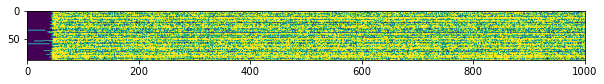

In [70]:
model = BaseLSTM
model_val = "BEST"
run = 4
seq,path=generate_sample(model,model_val,run,musicname="black_key.mid",
            len_input_seq=1000,ln=1000,tmp=1,model_name="BaseLSTM2",start_position=0)
print(path)

In [67]:
F.midiwrite(path, seq, dtm=0.1)

### with only final 1000 loss - BaseLSTM3 model

Handcrafted Dataset - Generated Music/BaseLSTM3/run6-BEST-waldstein_1.mid


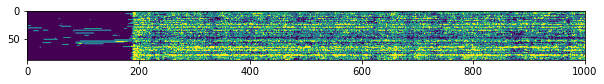

In [25]:
model = BaseLSTM
model_val = "BEST"
run = 6
seq,path=generate_sample(model,model_val,run,musicname="waldstein_1.mid",
            len_input_seq=2000,ln=1000,tmp=1,model_name="BaseLSTM3",start_position=0)
print(path)

In [26]:
F.midiwrite(path, seq, dtm=0.1)

### with 1000 input and output sequence - BaseLSTM4 model

Handcrafted Dataset - Generated Music/BaseLSTM4/run5-BEST-waldstein_1.mid


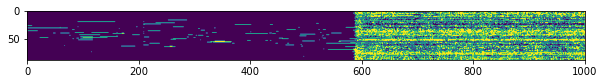

In [24]:
model = BaseLSTM
model_val = "BEST"
run = 5
seq,path=generate_sample(model,model_val,run,musicname="waldstein_1.mid",
            len_input_seq=2000,ln=1000,tmp=1,model_name="BaseLSTM4",start_position=0)
print(path)

In [25]:
F.midiwrite(path, seq, dtm=0.1)

### with 500 input and output sequence - BaseLSTM5 model

Handcrafted Dataset - Generated Music/BaseLSTM5/run4-BEST-waldstein_1.mid


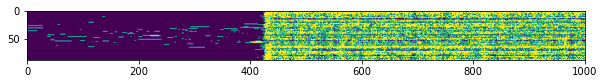

In [20]:
model = BaseLSTM
model_val = "BEST"
run = 4
seq,path=generate_sample(model,model_val,run,musicname="waldstein_1.mid",
            len_input_seq=2000,ln=1000,tmp=1,model_name="BaseLSTM5",start_position=0)
print(path)